<a href="https://colab.research.google.com/github/adefauziah/adenf/blob/master/proyek_2_time_series_Ade_Nurul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving DailyDelhiClimateTrain.csv to DailyDelhiClimateTrain.csv
User uploaded file "DailyDelhiClimateTrain.csv" with length 78199 bytes


In [ ]:
import io
data_train=pd.read_csv(io.StringIO(uploaded['DailyDelhiClimateTrain.csv'].decode('utf-8')),sep=',')
data_train

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [ ]:
data_train.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

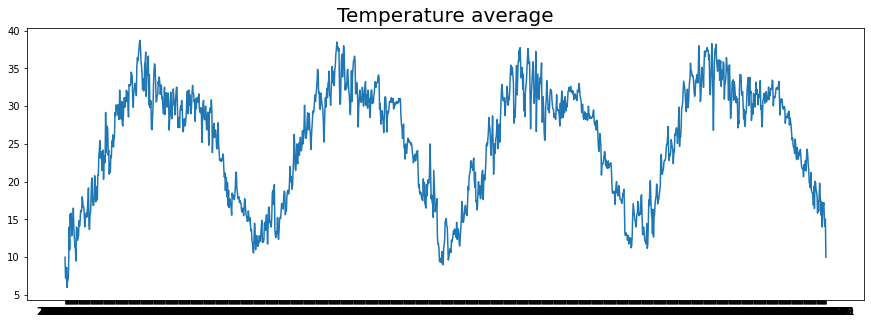

In [ ]:
dates = data_train['date'].values
temp  = data_train['meantemp'].values
       
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',fontsize=20);

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_train['date'],data_train['meantemp'], test_size = 0.2, shuffle = False)
print(len(X_train),len(X_test), len(y_train), len(y_test))

1169 293 1169 293


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(y_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(y_test, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.LSTM(60, return_sequences=True),
                                    tf.keras.layers.LSTM(60),
                                    tf.keras.layers.Dense(30, activation="relu"),
                                    tf.keras.layers.Dense(10, activation="relu"),
                                    tf.keras.layers.Dense(1),
                                    ])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.1):
      print("\nMAE <10%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100,validation_data = val_set,callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
12/12 [==============================] - 5s 168ms/step - loss: 22.9959 - mae: 23.4959 - val_loss: 26.5222 - val_mae: 27.0222
Epoch 2/100
12/12 [==============================] - 1s 93ms/step - loss: 22.8490 - mae: 23.3490 - val_loss: 26.3246 - val_mae: 26.8246
Epoch 3/100
12/12 [==============================] - 1s 95ms/step - loss: 22.6282 - mae: 23.1282 - val_loss: 26.0710 - val_mae: 26.5710
Epoch 4/100
12/12 [==============================] - 1s 93ms/step - loss: 22.3572 - mae: 22.8572 - val_loss: 25.7675 - val_mae: 26.2675
Epoch 5/100
12/12 [==============================] - 1s 94ms/step - loss: 22.0375 - mae: 22.5375 - val_loss: 25.4148 - val_mae: 25.9148
Epoch 6/100
12/12 [==============================] - 1s 92ms/step - loss: 21.6692 - mae: 22.1692 - val_loss: 25.0104 - val_mae: 25.5104
Epoch 7/100
12/12 [==============================] - 1s 94ms/step - loss: 21.2418 - mae: 21.7418 - val_loss: 24.5380 - val_mae: 25.0380
Epoch 8/100
12/12 [============================

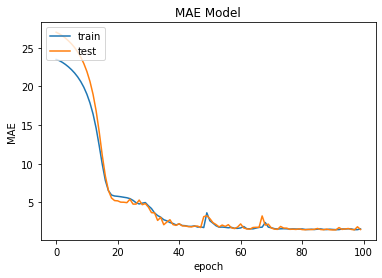

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

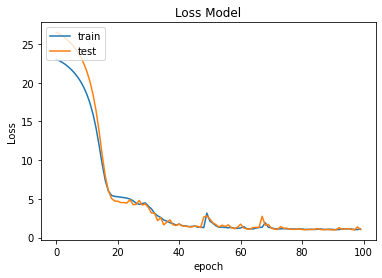

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()